In [53]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [54]:
df = pd.read_csv("House-Prices.csv")
df['n_hos_beds'].fillna(df['n_hos_beds'].mode()[0], inplace= True)
df['waterbody'].fillna(df['waterbody'].mode()[0], inplace= True)
df.drop(columns = 'bus_ter', inplace = True)
df.head()


/tmp/ipykernel_113504/3598158459.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['n_hos_beds'].fillna(df['n_hos_beds'].mode()[0], inplace= True)
/tmp/ipykernel_113504/3598158459.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

,price,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,parks,Sold
0,24.0,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,YES,5.480,11.1920,River,23,0.049347,0
1,21.6,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,NO,7.332,12.1728,Lake,42,0.046146,1
2,34.7,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,NO,7.394,101.1200,River,38,0.045764,0
3,33.4,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,YES,9.268,11.2672,Lake,45,0.047151,0
4,36.2,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,NO,8.824,11.2896,Lake,55,0.039474,0


Задание 1

1. Исключите сильно коррелированные независимые переменные. Под «слишком высокой» корреляцией можно понимать абсолютное значение коэффициента корреляции выше 0.9. Это поможет избежать проблемы мультиколлинеарности в модели.

2. Преобразуйте категориальные переменные в числовой формат при по-
мощи кодирования фиктивными переменными (также известного как «одноразрядное кодирование» или one-hot кодирование). Это позволит модели корректно работать с категориальной информацией.

3. Проверьте, не улучшится ли связь некоторых признаков с зависимой
переменной при применении различных преобразований (например, логарифмирования или взятия квадратного корня). Если после преобразования переменной её корреляция с целевой переменной увеличивается, используйте преобразованную версию этой переменной.

In [55]:
def find_highly_correlated_features(df, threshold=0.9):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()
    
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    high_corr_pairs = [
        (column, index) 
        for column in upper_tri.columns 
        for index, value in upper_tri[column].items() 
        if value > threshold
    ]
    
    return high_corr_pairs, corr_matrix

def drop_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.select_dtypes(include=[np.number]).corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = set()
    for column in upper_tri.columns:
        for index, value in upper_tri[column].items():
            if value > threshold:
                to_drop.add(index)  
    
    df_clean = df.drop(columns=to_drop)
    print(f"Удалены признаки: {list(to_drop)}")
    print(f"Осталось признаков: {df_clean.shape[1]}")
    return df_clean

def check_transformations(df, target_col, threshold=0.05):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    numeric_cols = [col for col in numeric_cols if col != target_col]
    
    results = []
    
    for col in numeric_cols:
        original_corr = df[col].corr(df[target_col])
        
        
        if (df[col] <= 0).any():
            results.append({
                'feature': col,
                'original_corr': original_corr,
                'log_corr': np.nan,
                'sqrt_corr': np.nan,
                'best_transform': 'none',
                'improvement': 0
            })
            continue
            
        log_col = np.log(df[col])
        log_corr = log_col.corr(df[target_col])
        
        sqrt_col = np.sqrt(df[col])
        sqrt_corr = sqrt_col.corr(df[target_col])

        correlations = {
            'none': abs(original_corr),
            'log': abs(log_corr),
            'sqrt': abs(sqrt_corr)
        }
        
        best = max(correlations, key=correlations.get)
        improvement = correlations[best] - abs(original_corr)
        
        results.append({
            'feature': col,
            'original_corr': original_corr,
            'log_corr': log_corr,
            'sqrt_corr': sqrt_corr,
            'best_transform': best,
            'improvement': improvement
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('improvement', ascending=False)

    df_transformed = df.copy()
    for _, row in results_df.iterrows():
        if row['best_transform'] == 'log' and row['improvement'] > threshold:
            new_col = f"log_{row['feature']}"
            df_transformed[new_col] = np.log(df_transformed[row['feature']])
            print(f"Применено log для {row['feature']}: corr {row['original_corr']:.3f} → {row['log_corr']:.3f}")
        elif row['best_transform'] == 'sqrt' and row['improvement'] > threshold:
            new_col = f"sqrt_{row['feature']}"
            df_transformed[new_col] = np.sqrt(df_transformed[row['feature']])
            print(f"Применено sqrt для {row['feature']}: corr {row['original_corr']:.3f} → {row['sqrt_corr']:.3f}")
    
    print("\nТОП-10 улучшений корреляции:")
    print(results_df.head(10)[['feature', 'original_corr', 'log_corr', 'sqrt_corr', 'best_transform', 'improvement']])
    
    top_features = results_df.head(6)['feature'].tolist()
    plt.figure(figsize=(15, 8))
    for i, feat in enumerate(top_features, 1):
        plt.subplot(2, 3, i)
        row = results_df[results_df['feature'] == feat].iloc[0]
        
        if row['best_transform'] == 'log':
            transformed = np.log(df[feat])
            plt.scatter(transformed, df[target_col], alpha=0.5)
            plt.title(f"log({feat})\nкорр = {row['log_corr']:.3f}")
        elif row['best_transform'] == 'sqrt':
            transformed = np.sqrt(df[feat])
            plt.scatter(transformed, df[target_col], alpha=0.5)
            plt.title(f"sqrt({feat})\nкорр = {row['sqrt_corr']:.3f}")
        else:
            plt.scatter(df[feat], df[target_col], alpha=0.5)
            plt.title(f"{feat}\nкорр = {row['original_corr']:.3f}")
        
        plt.xlabel(f"Преобразованный {feat}")
        plt.ylabel(target_col)
    
    plt.tight_layout()
    plt.show()
    
    return df_transformed, results_df

  dist2 и dist1: r = 0.9979
  dist3 и dist1: r = 0.9977
  dist3 и dist2: r = 0.9981
  dist4 и dist1: r = 0.9941
  dist4 и dist2: r = 0.9940
  dist4 и dist3: r = 0.9941
  parks и air_qual: r = 0.9155


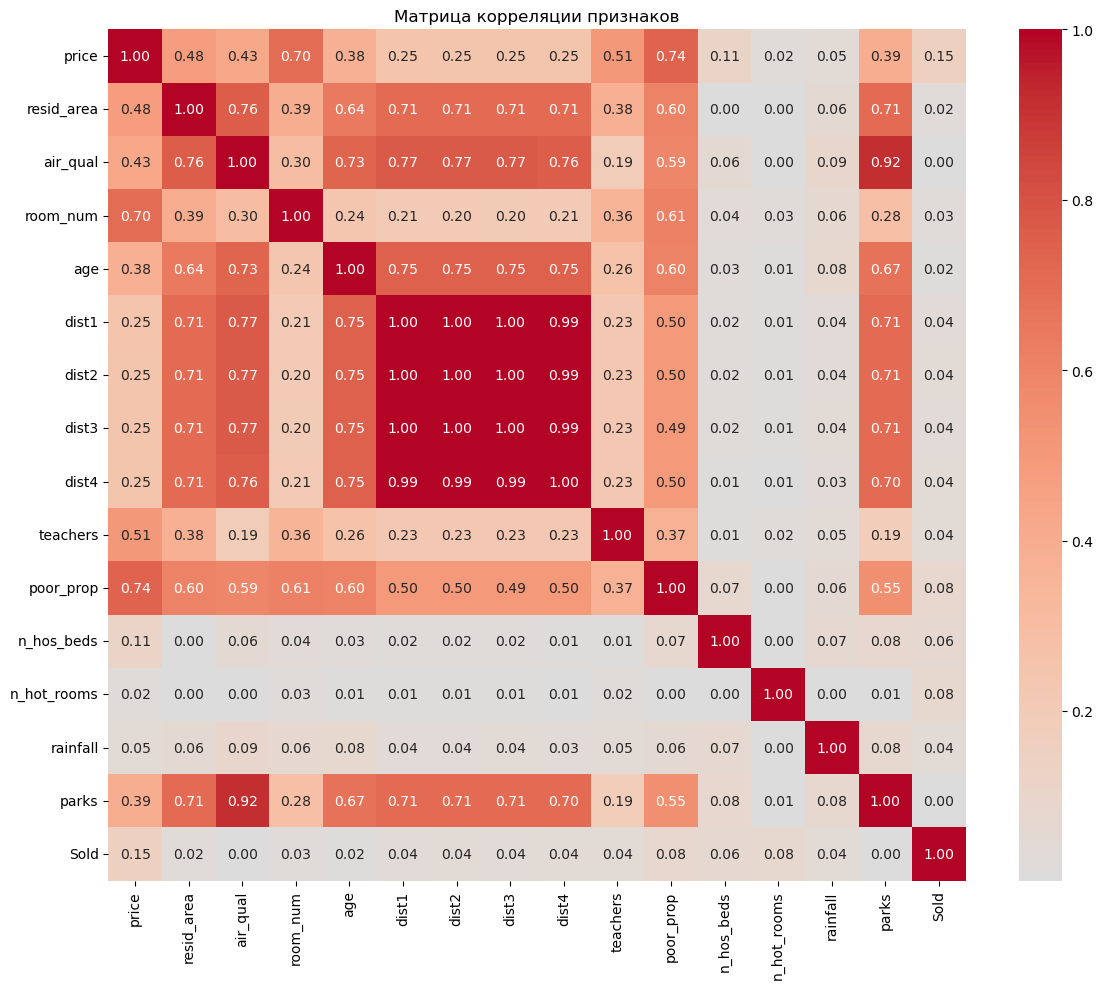

Удалены признаки: ['air_qual', 'dist2', 'dist3', 'dist1']
Осталось признаков: 14
Применено log для poor_prop: corr -0.741 → -0.818
Применено log для dist4: corr 0.248 → 0.295

ТОП-10 улучшений корреляции:
       feature  original_corr  log_corr  sqrt_corr best_transform  improvement
5    poor_prop      -0.740836 -0.818237  -0.788192            log     0.077401
3        dist4       0.248200  0.295034   0.274663            log     0.046834
8     rainfall      -0.047426 -0.060710  -0.053865            log     0.013283
0   resid_area      -0.484754 -0.496515  -0.490860            log     0.011760
4     teachers       0.505655  0.508225   0.507079            log     0.002571
1     room_num       0.696304  0.661028   0.680314           none     0.000000
2          age      -0.377999 -0.326556  -0.359735           none     0.000000
6   n_hos_beds       0.114401  0.114317   0.114219           none     0.000000
7  n_hot_rooms       0.023122  0.021315   0.022125           none     0.000000
9    

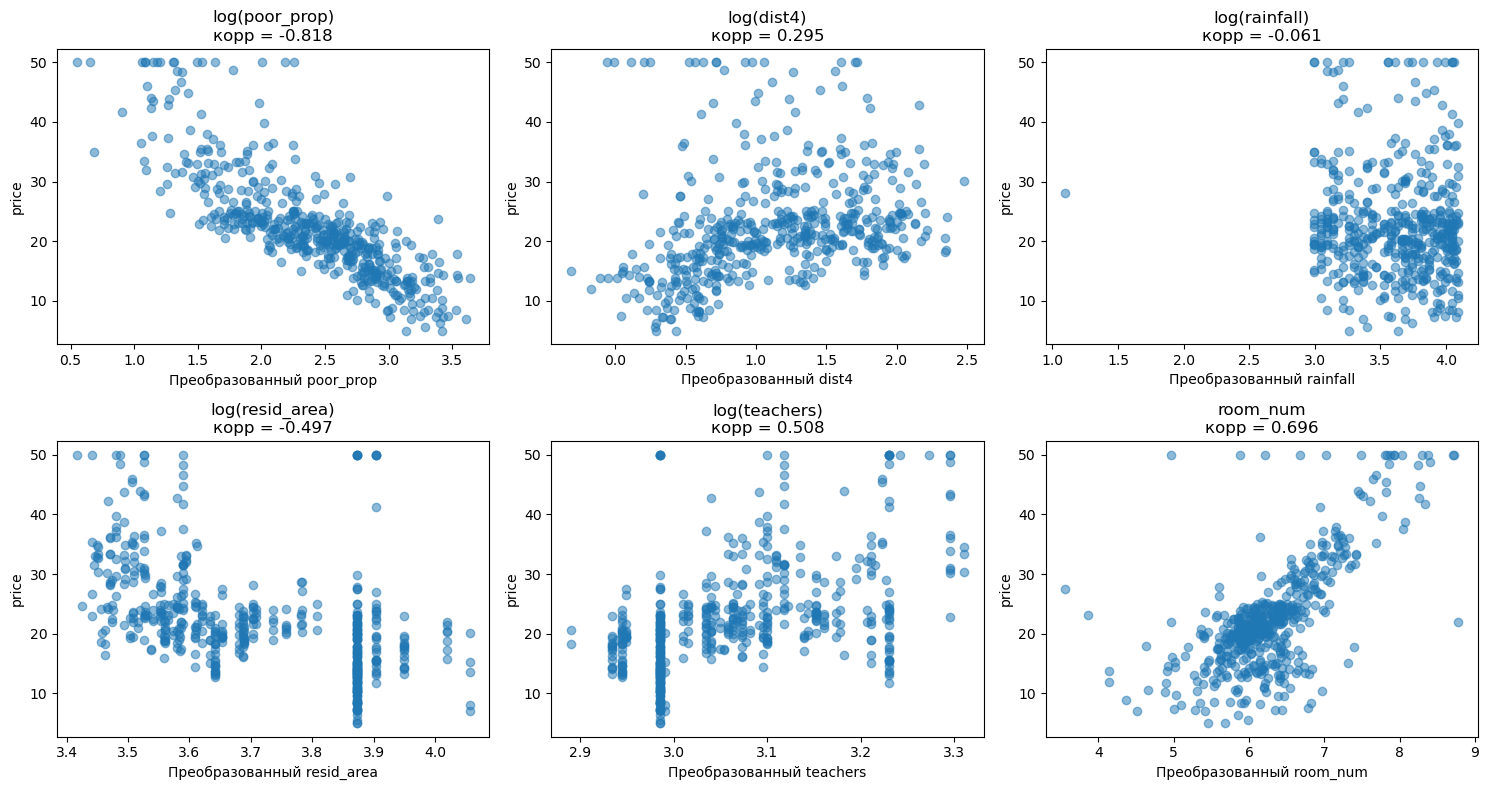

In [56]:

high_corr_pairs, corr_matrix = find_highly_correlated_features(df, threshold=0.9)
if high_corr_pairs:
    for col1, col2 in high_corr_pairs:
        corr = corr_matrix.loc[col1, col2]
        print(f"  {col1} и {col2}: r = {corr:.4f}")
else:
    print(" => Таких пар НЕТ")


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляции признаков')
plt.tight_layout()
plt.show()


df = drop_highly_correlated_features(df, threshold=0.9)

df_transformed, df_result = check_transformations(df, 'price', threshold=0.03)


In [57]:
cat_col = ['airport', 'waterbody']
cat_data = df[cat_col]

ohe = OneHotEncoder(drop='first', sparse_output= False, handle_unknown= 'ignore')
oneHotData = ohe.fit_transform(cat_data)
feature_names = ohe.get_feature_names_out(cat_col)

oneHot_df = pd.DataFrame(oneHotData, columns=feature_names, index=df.index)

df = df.drop(columns=cat_col).join(oneHot_df)

Задание No 2
Напишите функцию, которая:
• Принимает на вход любой набор переменных в виде списка строк;

• Находит оценки для соответствующих параметров линейной регрес-
сии;

• Находит приближения для ошибок линейной регрессии, а также оценку $\alpha^2$ их дисперсии $\alpha^2$
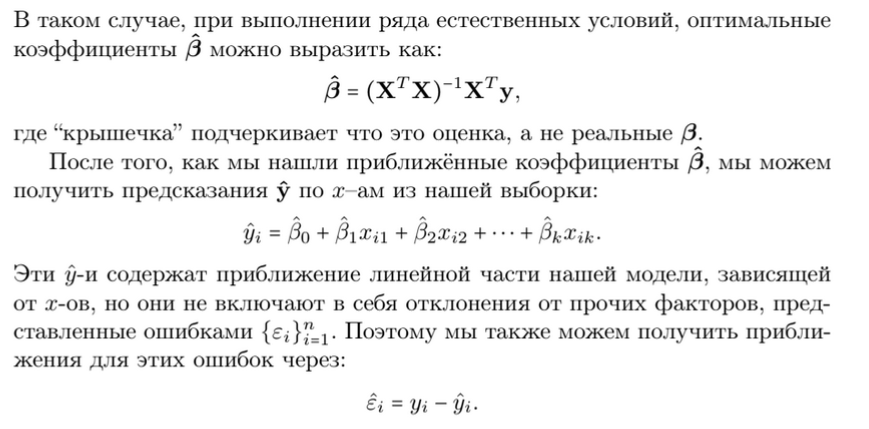

In [58]:
def computeAssestment(df, target_col, feature_cols):
    
    X = np.column_stack([np.ones(len(df)), df[feature_cols].values])
    Y = df[target_col].values

    XtX = X.T @ X
    X_inv = np.linalg.pinv(XtX)
    XtY = X.T @ Y
    beta = X_inv @ XtY

    y_pred = X @ beta

    err = Y - y_pred

    n = len(Y)
    feature_num = len(feature_cols)
    sigma2 = np.sum(err**2)/(n - feature_num - 1)

    print("Оценки коэффициентов линейной регрессии:")
    print(f" beta = {beta[0]:.4f}")
    for i, col in enumerate(feature_cols):
        print(f"  beta_{i+1} ({col})     = {beta[i+1]:.4f}")
    print(f"\nОценка дисперсии ошибок sigma^2 = {sigma2:.4f}")
    print(f"Стандартное отклонение ошибок sigma = {np.sqrt(sigma2):.4f}")

    return beta, err, sigma2



In [59]:
feature_cols = df.drop('price', axis=1).columns.tolist()
beta, err, sigma2 = computeAssestment(df, 'price', feature_cols)

Оценки коэффициентов линейной регрессии:
 beta = -4.3120
  beta_1 (resid_area)     = -0.0787
  beta_2 (room_num)     = 3.9352
  beta_3 (age)     = -0.0151
  beta_4 (dist4)     = -1.1491
  beta_5 (teachers)     = 0.9636
  beta_6 (poor_prop)     = -0.6368
  beta_7 (n_hos_beds)     = 0.4446
  beta_8 (n_hot_rooms)     = 0.0105
  beta_9 (rainfall)     = 0.0055
  beta_10 (parks)     = -80.2121
  beta_11 (Sold)     = -4.1219
  beta_12 (airport_YES)     = 0.8952
  beta_13 (waterbody_Lake and River)     = -0.7699
  beta_14 (waterbody_River)     = -0.2277

Оценка дисперсии ошибок sigma^2 = 20.7027
Стандартное отклонение ошибок sigma = 4.5500


Задание No 3
Напишите функцию, которая, по обученной модели линейной регрессии,
проводит тест на значимость любого указанного ей коэффициента $\Beta^s$. Для этого:
• Найдите оценку дисперсии $\Beta ^ s$, используя вместо $\sigma^2$ оценку регрессионных ошибок из предыдущего задания;

• Найдите стандартизацию коэффициента $\hat{\Beta}_{s}^{st}$ при условии выполнения основной гипотезы $H_{0}$;

• Предполагая, что стандартизация $\hat{\Beta}_{s}^{st}$ имеет приблизительно стандартное нормальное распределение и что более “экстремальными” (более указывающими на альтернативную гипотезу) значениями являются большие по модулю значения, найдите p–value для этого теста.

In [61]:
from scipy.stats import norm
def computeSignificance(df, target_col, feature_cols, s, beta, sigma2):

    X = np.column_stack([np.ones(len(df)), df[feature_cols].values])
    Y = df[target_col].values

    cov_beta = np.linalg.pinv(X.T @ X) * sigma2

    var_beta = cov_beta[s, s]

    t_stat = beta[s] / np.sqrt(var_beta)

    p_value = 2 * (1 - norm.cdf(np.abs(t_stat)))

    return var_beta, t_stat, p_value


In [63]:
var_beta_0, t_stat, p_value = computeSignificance(df, 'price', feature_cols, 0, beta, sigma2)
print(f"var_beta_0: {var_beta_0:.4f} ,\nt_stat: {t_stat:.4f},\np_value: {p_value:.4f}")

var_beta_0: 22.2429 ,
t_stat: -0.9143,
p_value: 0.3606


Напишите код на Python, который работает с исходным набором данных о
домах и реализует следующую идею.
Разделите дома по типу водоёма в признаке waterbody (значения None,
River, Lake, Lake and River).

Пользователь должен задать своё предположение о вероятности прода-
жи дома в каждой группе (априорное математическое ожидание p), а так-
же степень «неуверенности» в этом предположении (априорное стандартное

отклонение). Считаем, что априор для p задаётся бета-распределением. Ис-
пользуя исходный априор и данные по каждой подгруппе, для каждой груп-
пы найдите апостериорное распределение p и выведите его математическое

ожидание и стандартное отклонение. После этого сравните группы между
собой: где вероятность продажи выше, где ниже, и как сильно изменилась
неопределённость по сравнению с априором.

Далее нужно показать, как выглядят последовательные байесовские об-
новления при объединении групп. Начните с априора по предположениям

пользователя о продаже домов в группе None и обновите его по данным
этой группы, получив первый апостериор. Затем возьмите этот апостериор

как новый априор и обновите его по данным второй группы, снова посчи-
тав апостериорные среднее и стандартное отклонение. Продолжайте так в

выбранном порядке, шаг за шагом объединяя группы и отслеживая, как
меняются параметры распределения p после каждого обновления.

Нарисуйте графики исходного априора, заданного пользователем, и всех

полученных после обновлений апостериоров, чтобы было видно, как распре-
деление постепенно уточняется под воздействием данных.

In [64]:
from scipy.stats import beta

def mean_std_to_beta(mean, std):
    if mean <= 0 or mean >= 1 or std <= 0:
        raise ValueError("mean in (0,1), std > 0")
    val = mean * (1 - mean) / std**2 - 1
    a = mean * val
    b = (1 - mean)*val
    return a, b

def update_beta(prior_a, prior_b, successes, trials):
    post_a = prior_a + successes
    post_b = prior_b + (trials - successes)
    post_mean = post_a / (post_a + post_b)
    post_std = np.sqrt(post_a * post_b / ((post_a + post_b)**2 * (post_a + post_b + 1)))
    return post_a, post_b, post_mean, post_std

Априор: Beta(a=0.00, b=0.00)

Группа 'None':
  Данных: 0 домов, продано: 0
  Апостериорное среднее p: nan
  Апостериорное ст.отклонение: nan
  Изменение неопределённости: априор 0.5000 → nan (+nan%)

Группа 'River':
  Данных: 183 домов, продано: 92
  Апостериорное среднее p: 0.5027
  Апостериорное ст.отклонение: 0.0369
  Изменение неопределённости: априор 0.5000 → 0.0369 (-92.6%)

Группа 'Lake':
  Данных: 97 домов, продано: 38
  Апостериорное среднее p: 0.3918
  Апостериорное ст.отклонение: 0.0493
  Изменение неопределённости: априор 0.5000 → 0.0493 (-90.1%)

Группа 'Lake and River':
  Данных: 71 домов, продано: 32
  Апостериорное среднее p: 0.4507
  Апостериорное ст.отклонение: 0.0586
  Изменение неопределённости: априор 0.5000 → 0.0586 (-88.3%)

Сравнение вероятностей продажи по группам:
  None: p = nan
  River: p = 0.5027
  Lake and River: p = 0.4507
  Lake: p = 0.3918
После обновления по 'None':
  Среднее p: nan
  Ст.отклонение: nan

После обновления по 'River':
  Среднее p: 0.5027

/tmp/ipykernel_113504/1276086494.py:14: RuntimeWarning: invalid value encountered in scalar divide
  post_mean = post_a / (post_a + post_b)
/tmp/ipykernel_113504/1276086494.py:15: RuntimeWarning: invalid value encountered in scalar divide
  post_std = np.sqrt(post_a * post_b / ((post_a + post_b)**2 * (post_a + post_b + 1)))


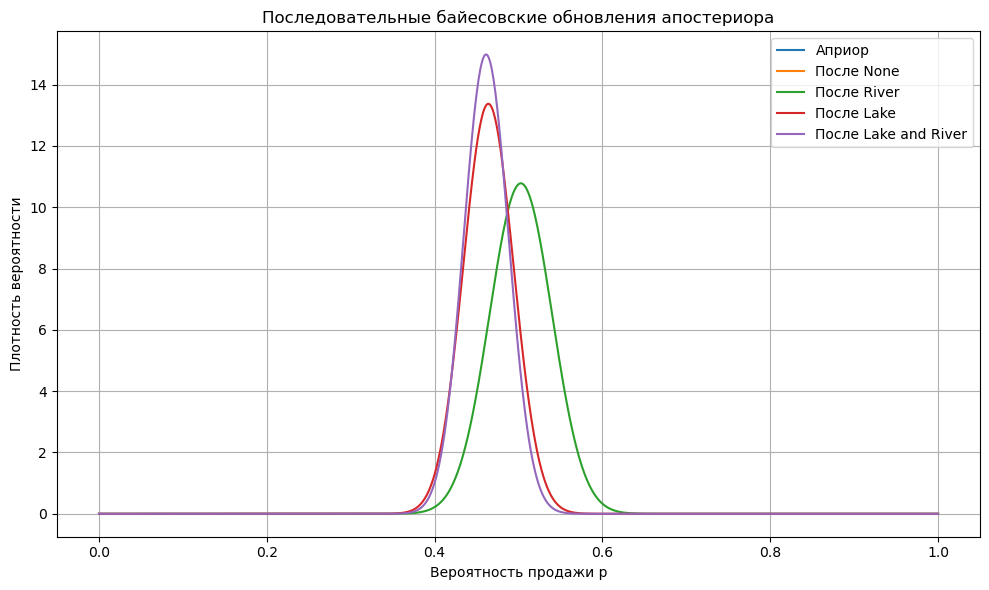

In [65]:
df = pd.read_csv('House-Prices.csv')

prior_mean = float(input("введите априорное мат ожидание"))
prior_std = float(input("Введите априорное стандартное отклонение"))

prior_a, prior_b = mean_std_to_beta(prior_mean, prior_std)
print(f"Априор: Beta(a={prior_a:.2f}, b={prior_b:.2f})\n")

groups = ['None', 'River', 'Lake', 'Lake and River']

group_stats = {}
for group in groups:
    group_df = df[df['waterbody'] == group]
    trials = len(group_df)
    successes = group_df['Sold'].sum()
    group_stats[group] = (successes, trials)

# pt1
posteriors = {}
for group in groups:
    successes, trials = group_stats[group]
    post_a, post_b, post_mean, post_std = update_beta(prior_a, prior_b, successes, trials)
    posteriors[group] = (post_a, post_b, post_mean, post_std)
    
    print(f"Группа '{group}':")
    print(f"  Данных: {trials} домов, продано: {successes}")
    print(f"  Апостериорное среднее p: {post_mean:.4f}")
    print(f"  Апостериорное ст.отклонение: {post_std:.4f}")
    print(f"  Изменение неопределённости: априор {prior_std:.4f} → {post_std:.4f} ({(post_std - prior_std)/prior_std*100:+.1f}%)\n")

means = {group: posteriors[group][2] for group in groups}
sorted_groups = sorted(means, key=means.get, reverse=True)
print("Сравнение вероятностей продажи по группам:")
for group in sorted_groups:
    print(f"  {group}: p = {means[group]:.4f}")

# pt2
current_a = prior_a
current_b = prior_b
sequential_posteriors = [(current_a, current_b)]  
labels = ['Априор']

for group in groups:
    successes, trials = group_stats[group]
    current_a, current_b, post_mean, post_std = update_beta(current_a, current_b, successes, trials)
    sequential_posteriors.append((current_a, current_b))
    labels.append(f'После {group}')
    
    print(f"После обновления по '{group}':")
    print(f"  Среднее p: {post_mean:.4f}")
    print(f"  Ст.отклонение: {post_std:.4f}\n")

# pt3
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))

for i, (a, b) in enumerate(sequential_posteriors):
    plt.plot(x, beta.pdf(x, a, b), label=labels[i])

plt.title('Последовательные байесовские обновления апостериора')
plt.xlabel('Вероятность продажи p')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()